In [1]:
import sys
sys.path.append('/u/ajagadish/ermi/categorisation/')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import json
from collections import Counter, defaultdict
from wordcloud import WordCloud
from mycolorpy import colorlist as mcp
import torch.nn as nn
import math
import ivon
from torch.distributions import Normal
from torch.distributions.kl import kl_divergence
from torch.distributions import MultivariateNormal, Gamma
import torch.nn.utils.rnn as rnn_utils
FONTSIZE=20
SYS_PATH = '/u/ajagadish/ermi' #'/raven/u/ajagadish/vanilla-llama/'

In [62]:
aa= torch.tensor([[-4.5833e-01,  0.0000e+00],
        [-1.6667e-01, -3.8355e-01],
        [ 4.5833e-01, -5.5747e-02],
        [-4.1667e-02,  4.9100e-01],
        [ 3.3333e-01, -1.1159e-01],
        [ 8.3333e-02,  3.2862e-01],
        [-2.0833e-01, -1.3772e-02],
        [ 1.6667e-01, -1.5397e-01],
        [-8.3334e-02,  7.5127e-02],
        [ 4.1666e-02, -1.3435e-02],
        [ 2.5000e-01,  1.8507e-01],
        [ 3.7500e-01,  1.4646e-01],
        [-3.3333e-01,  3.2007e-01],
        [ 5.0000e-01, -5.0000e-01],
        [ 2.9167e-01,  2.7462e-01],
        [-1.2500e-01,  4.0850e-01],
        [-5.0000e-01,  1.6861e-02],
        [-2.3842e-07, -4.5374e-01],
        [ 1.2500e-01, -1.4884e-01],
        [-2.9167e-01,  3.4116e-01],
        [-4.1667e-01, -1.5988e-01],
        [ 4.1667e-01, -3.5308e-01],
        [-2.5000e-01,  4.9999e-01],
        [ 2.0833e-01, -3.1683e-01],
        [-3.7500e-01,  1.1261e-01]])

In [64]:
bb = torch.tensor([-0.3835, -0.0557,  0.4910, -0.1116,  0.3286, -0.0138, -0.1540,  0.0751,
        -0.0134,  0.1851,  0.1465,  0.3201, -0.5000,  0.2746,  0.4085,  0.0169,
        -0.4537, -0.1488,  0.3412, -0.1599, -0.3531,  0.5000, -0.3168,  0.1126,
        -0.3403])

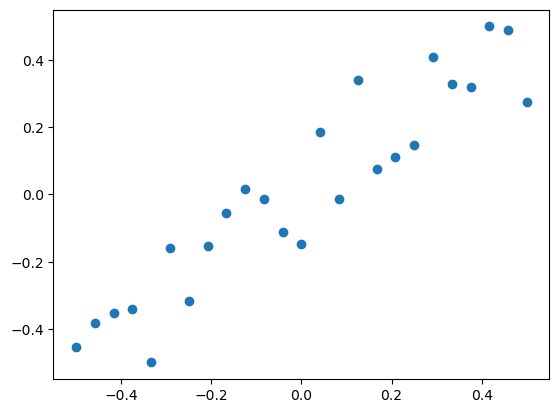

In [65]:
plt.scatter(aa[:,0], bb)

In [47]:
env = SyntheticFunctionlearningTask(batch_size=5)
data = env.sample_batch()

In [48]:
x, s, y = data

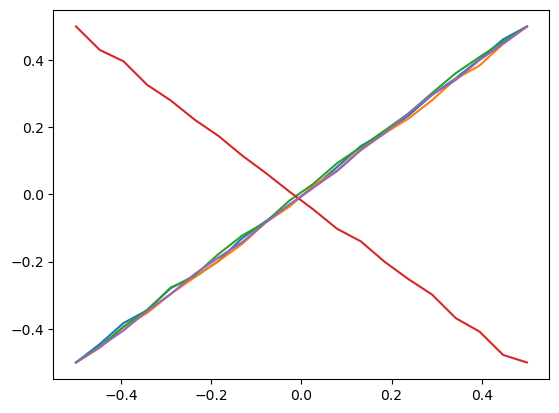

In [49]:
for xx, _, yy in zip(x, s, y):
    plt.plot(xx[:,0], yy)

In [45]:
env.save_data(num_batches=10)

In [221]:
class SyntheticFunctionlearningTask(nn.Module):
    """
    Synthetic function learning from Lucas et al. 2015
    """

    def __init__(self, max_steps=20, sample_to_match_max_steps=False, num_dims=3, scale=0.5, batch_size=64, mode='train', split=[0.8, 0.1, 0.1], device='cpu', num_tasks=10000, noise=0., shuffle_trials=False, shuffle_features=True, normalize_inputs=True):
        """
        Initialise the environment
        Args:
            data: path to csv file containing data
            max_steps: number of steps in each episode
            num_dims: number of dimensions in each input
            batch_size: number of tasks in each batch
        """
        super(SyntheticFunctionlearningTask, self).__init__()
    
        self.device = torch.device(device)
        self.max_steps = max_steps
        self.sample_to_match_max_steps = sample_to_match_max_steps
        self.num_choices = 1
        self.batch_size = batch_size
        self.num_dims = num_dims
        self.mode = mode
        self.scale = scale
        self.noise = noise
        self.shuffle_trials = shuffle_trials
        self.shuffle_features = shuffle_features
        self.normalize = normalize_inputs

    def sample_parameters(self):
        # shape and scale from Lucas et al. 2015
        return torch.distributions.Gamma(1.001, 1.).sample((self.batch_size,))
    
    def positive_linear(self, x, weight, intercept):
        return weight[:, None] * x + intercept[:, None]

    def negative_linear(self, x, weight, intercept):
        return -weight[:, None] * x + intercept[:, None]

    def quadratic(self, x, weight, intercept):
        return weight[:, None] * x**2 + intercept[:, None]

    def radial_basis(self, x, height, distance):
        return height[:, None] * torch.exp(-distance[:, None] * x**2)


    def sample_batch_vectorized(self, noise=0.1):
        
        x = torch.linspace(-1, 1, self.max_steps, device=self.device)
        prior_probs = [0, 0, 0, 1]
        kernel_types = ['positive_linear', 'negative_linear', 'quadratic', 'radial_basis']
        kernel_choices = np.random.choice(kernel_types, size=self.batch_size, p=np.array(prior_probs) / sum(prior_probs))
   
        weights = self.sample_parameters()
        intercepts = self.sample_parameters()
        heights = self.sample_parameters()
        distances = self.sample_parameters()

        y_batch = torch.zeros((self.batch_size, self.max_steps), device=self.device)

        positive_linear_mask = kernel_choices == 'positive_linear'
        negative_linear_mask = kernel_choices == 'negative_linear'
        quadratic_mask = kernel_choices == 'quadratic'
        radial_basis_mask = kernel_choices == 'radial_basis'
        
        y_batch[positive_linear_mask] = self.positive_linear(x, weights[positive_linear_mask], intercepts[positive_linear_mask])
        y_batch[negative_linear_mask] = self.negative_linear(x, weights[negative_linear_mask], intercepts[negative_linear_mask])
        y_batch[quadratic_mask] = self.quadratic(x, weights[quadratic_mask], intercepts[quadratic_mask])
        y_batch[radial_basis_mask] = self.radial_basis(x, heights[radial_basis_mask], distances[radial_basis_mask])

        y_batch += noise * torch.randn(self.batch_size, self.max_steps)
        x_batch = x.tile((self.batch_size,)).reshape(self.batch_size, self.max_steps)
        
        return y_batch, x_batch

    
    def sample_batch(self):

        # data: input, target, shifted target
        targets, inputs  = self.sample_batch_vectorized()

        # normalize the data
        def stacked_normalized(data, scale):
            data_min = data.min(dim=1, keepdim=True).values
            data_max = data.max(dim=1, keepdim=True).values
            return 2 * scale * (data - data_min) / (data_max - data_min + 1e-6) - scale

        targets = stacked_normalized(targets, self.scale) if self.normalize else targets
        inputs = stacked_normalized(inputs, self.scale) if self.normalize else inputs
        shifted_targets = torch.concatenate((torch.zeros(self.batch_size, 1), targets[:, :-1]), dim=1)
        
        # concatenate inputs and targets
        stacked_task_features = aa
        stacked_targets = targets
        sequence_lengths = [len(task_input_features)
                            for task_input_features in inputs]
        
        packed_inputs = rnn_utils.pad_sequence(
            stacked_task_features, batch_first=True)
        
       
        return packed_inputs.to(self.device), sequence_lengths, stacked_targets
    
    def save_data(self):
        pass

In [222]:
env = SyntheticFunctionlearningTask(batch_size=5)
data = env.sample_batch()

In [223]:
x, s, y = data

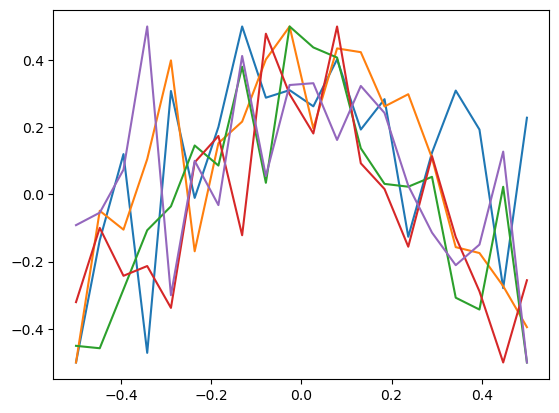

In [224]:
for xx, _, yy in zip(x, s, y):
    plt.plot(xx[:,0], yy)

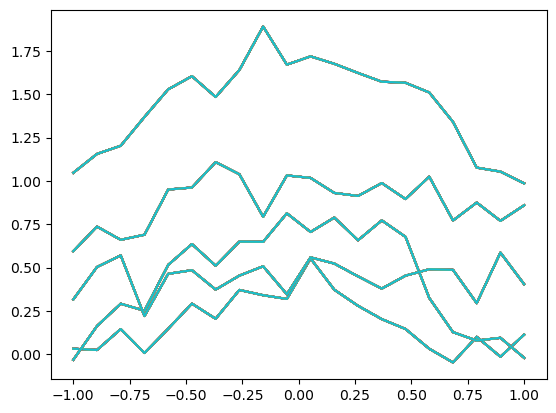

In [95]:
for task_id in data.task_id.values:
    d =data[data.task_id==task_id]
    plt.plot(d.input.values ,d.target.values)

In [598]:
import gpytorch
from gpytorch.kernels import RBFKernel, LinearKernel, PolynomialKernel
from torch.distributions import Beta, Bernoulli, Categorical, MultivariateNormal

In [709]:
def sample_function(num_points=5, scale=2, noise=0.0):
    kernel_probs = [8, 100, 0.1, 0.01]
    kernel_choice = np.random.choice(['positive_linear', 'negative_linear', 'quadratic', 'rbf'], p=np.array(kernel_probs) / np.sum(kernel_probs))
    print(kernel_choice)
    if kernel_choice == 'positive_linear':
        kernel = LinearKernel()
        kernel.variance = torch.distributions.Gamma(1.001, 1.0).sample()
        kernel.offset = torch.distributions.Gamma(10.001, 1.0).sample()
    elif kernel_choice == 'negative_linear':
        kernel = LinearKernel()
        kernel.variance = torch.distributions.Gamma(1.001, 1.0).sample()
        kernel.offset = -torch.distributions.Gamma(1.001, 1.0).sample()
    elif kernel_choice == 'quadratic':
        kernel = PolynomialKernel(power=2)
        kernel.variance = torch.distributions.Gamma(1.001, 1.0).sample()
        kernel.offset = torch.distributions.Gamma(1.001, 1.0).sample()
    elif kernel_choice == 'rbf':
        kernel = RBFKernel()
        kernel.lengthscale = torch.distributions.Gamma(1.001, 1.0).sample()

    x = torch.linspace(0, scale, num_points)
    mean = torch.zeros(num_points)
    cov = kernel(x).evaluate() + 1e-5 * torch.eye(num_points)
    # import ipdb; ipdb.set_trace()
    print(cov)
    y = MultivariateNormal(mean, cov).sample() + noise * torch.randn(num_points)

    data = pd.DataFrame({'input': x.numpy(), 'target': y.numpy()})
    return data

In [806]:
def sample_parameters():
        shape = 1.001
        scale = 1
        return torch.distributions.Gamma(shape, scale).sample()

def positive_linear(x, weight, intercept):
    return weight * x + intercept

def negative_linear(x, weight, intercept):
    return -weight * x + intercept

def quadratic(x, weight, intercept):
    return weight * x**2 + intercept

def radial_basis(x, height, distance):
    return height * np.exp(-distance * x**2)

def sample_function(num_points=24, scale=2, noise=0.1, batch_size=64):
    x = np.linspace(-1, 1, num_points)
    prior_probs =[8, 1, 0.1, 0.01]
    kernel_types = ['positive_linear', 'negative_linear', 'quadratic', 'radial_basis']
    kernel_choice = np.random.choice(kernel_types, p=np.array(prior_probs) / sum(prior_probs))
    kernel_choices = np.random.choice(kernel_types, size=batch_size, p=np.array(prior_probs) / sum(prior_probs))

    y_batch = []
    for kernel_choice in kernel_choices:
        if kernel_choice == 'positive_linear':
            weight = sample_parameters()
            intercept = sample_parameters()
            y = positive_linear(x, weight, intercept)
        elif kernel_choice == 'negative_linear':
            weight = sample_parameters()
            intercept = sample_parameters()
            y = negative_linear(x, weight, intercept)
        elif kernel_choice == 'quadratic':
            weight = sample_parameters()
            intercept = sample_parameters()
            y = quadratic(x, weight, intercept)
        elif kernel_choice == 'radial_basis':
            height = sample_parameters()
            distance = sample_parameters()
            y = radial_basis(x, height, distance)
    
        y += noise * np.random.randn(num_points)
        y_batch.append(y)
            
    return pd.DataFrame({'input': np.tile(x, batch_size), 'target': np.concatenate(y_batch)})

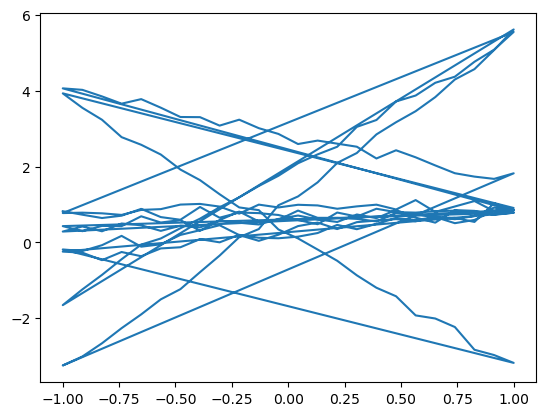

In [810]:
# Example usage
data = sample_function(batch_size=10)
# print(data)
plt.plot(data.input.values,data.target.values)

In [189]:
from torch.distributions import MultivariateNormal, Gamma

negative_linear
       input    target
0  -2.000000 -0.424581
1  -1.826087 -0.407537
2  -1.652174 -0.300859
3  -1.478261 -0.337293
4  -1.304348 -0.680004
5  -1.130435 -0.816131
6  -0.956522 -0.557805
7  -0.782609 -0.741049
8  -0.608696 -0.838550
9  -0.434783 -0.823192
10 -0.260870 -0.946874
11 -0.086956 -0.847802
12  0.086956 -1.281446
13  0.260870 -1.065772
14  0.434783 -1.159847
15  0.608696 -1.094037
16  0.782609 -1.314706
17  0.956522 -1.296803
18  1.130435 -1.326625
19  1.304348 -1.475814
20  1.478261 -1.608424
21  1.652174 -1.473785
22  1.826087 -1.588312
23  2.000000 -1.512008


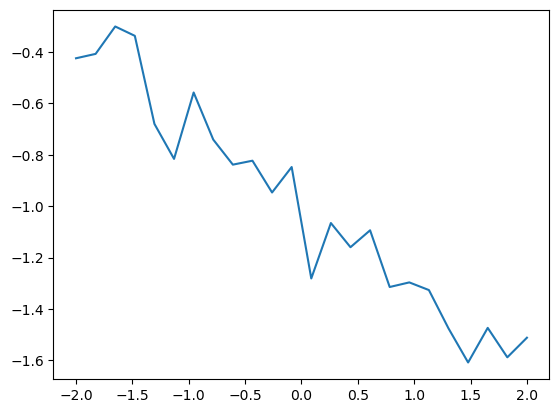

In [238]:
import torch
import gpytorch
import numpy as np
import pandas as pd
from gpytorch.kernels import LinearKernel, PolynomialKernel, RBFKernel, ScaleKernel
from gpytorch.priors import GammaPrior
from torch.distributions import MultivariateNormal

def sample_function(num_points=24, scale=2, noise=0.1):
    kernel_probs = [1, 8, 0.1, 0.01]
    kernel_choice = np.random.choice(
        ['positive_linear', 'negative_linear', 'quadratic', 'rbf'], 
        p=np.array(kernel_probs) / np.sum(kernel_probs)
    )
    
    offset = 0  # Default offset value, will adjust later for negative linear
    print(kernel_choice)
    if kernel_choice == 'positive_linear':
        kernel = ScaleKernel(LinearKernel())
        kernel.base_kernel.register_prior("raw_variance_prior", GammaPrior(1.001, 1.0), "raw_variance")
        
    elif kernel_choice == 'negative_linear':
        kernel = ScaleKernel(LinearKernel())
        kernel.base_kernel.register_prior("raw_variance_prior", GammaPrior(1.001, 1.0), "raw_variance")
        offset = -1  # Apply a negative offset after sampling
        
    elif kernel_choice == 'quadratic':
        kernel = ScaleKernel(PolynomialKernel(power=2))
        kernel.base_kernel.register_prior("raw_variance_prior", GammaPrior(1.001, 1.0), "raw_variance")
        
    elif kernel_choice == 'rbf':
        kernel = ScaleKernel(RBFKernel())
        kernel.base_kernel.register_prior("raw_lengthscale_prior", GammaPrior(1.001, 1.0), "raw_lengthscale")
    
    x = torch.linspace(-scale, scale, num_points)
    mean = torch.zeros(num_points)
    
    # Evaluate kernel on x and generate covariance matrix
    cov = kernel(x).to_dense() + 1e-5 * torch.eye(num_points)
    
    # Sample from the GP with noise and apply offset if necessary
    y = MultivariateNormal(mean, cov).sample() + noise * torch.randn(num_points) + offset

    # Convert to pandas DataFrame
    data = pd.DataFrame({'input': x.numpy(), 'target': y.numpy()})
    return data

# Example usage
data = sample_function()
print(data)
plt.plot(data.input.values,data.target.values)

In [244]:
cov_matrix

NameError: name 'cov_matrix' is not defined

In [ ]:
import torch
import gpytorch
from gpytorch.kernels import ScaleKernel, RBFKernel, LinearKernel, PolynomialKernel
from torch.distributions import Gamma

# Define kernel sampling based on prior probabilities
def sample_kernel():
    # Define the prior probabilities
    kernel_probs = torch.tensor([.01, 8.01, 0.01, 0.01])
    kernel_probs /= kernel_probs.sum()  # Normalize the probabilities

    # Sample a kernel type based on the prior probabilities
    kernel_choice = torch.multinomial(kernel_probs, 1).item()
    
    if kernel_choice == 0:
        # Positive linear kernel
        kernel = LinearKernel()
        kernel.variance = torch.distributions.Gamma(1.001, 1.0).sample()
        kernel.offset = torch.distributions.Gamma(1.001, 1.0).sample()
    elif kernel_choice == 1:
        # Negative linear kernel
        kernel = LinearKernel()
        kernel.variance = torch.distributions.Gamma(1.001, 1.0).sample()
        kernel.offset = torch.distributions.Gamma(1.001, 1.0).sample()
        kernel.variance *= -1  # Make it negative
    elif kernel_choice == 2:
        # Quadratic kernel
        kernel = ScaleKernel(PolynomialKernel(power=2, offset_prior=Gamma(1.001, 1.0)))
    else:
        # Radial Basis Function (RBF) kernel
        rbf_kernel = RBFKernel()
        rbf_kernel.raw_lengthscale_prior = Gamma(1.001, 1.0)
        kernel = ScaleKernel(rbf_kernel)

    return kernel

# Generate a sample GP model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = sample_kernel()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covardd_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Sample some data points
def generate_sample_1d_functions(num_samples=1):
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    sample_functions = []
    
    # Generate samples
    for _ in range(num_samples):
        train_x = torch.linspace(0, 1, 100)  # 1D input
        train_y = torch.zeros_like(train_x)  # Dummy data
        model = GPModel(train_x, train_y, likelihood)
        
        # Put model in evaluation mode
        model.eval()
        with torch.no_grad():
            observed_pred = model(train_x)
            sample_functions.append(observed_pred.sample().numpy())
    
    return sample_functions

# Example: Generate and plot one sample function
sample_functions = generate_sample_1d_functions(num_samples=1)
# print(sample_functions[0])
plt.plot(sample_functions[0])

RuntimeError: Attempting to manually set a parameter value that is out of bounds of its current constraints, Positive(). Most likely, you want to do the following:
 likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(better_lower_bound))

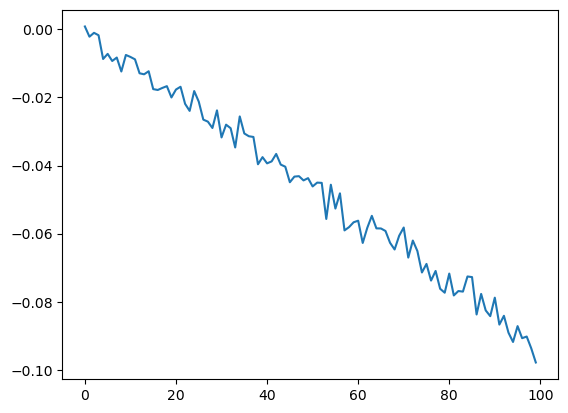

In [43]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.mean_W = nn.Parameter(torch.randn(1, 1))
        # self.mean_b = nn.Parameter(torch.randn(1))
        
    def forward(self, x):
        return x @ self.mean_W + self.mean_b

In [101]:
kls = []
ess = 10000000
for _ in range(10000):
    model = LinearModel()
    model_parameters =  model.parameters()
    optimizer = ivon.IVON(model_parameters, lr=lr, ess=ess_init, weight_decay=wd)
    kls.append(compute_kld(optimizer, std))

In [102]:
np.array(kls).mean()*151810

187701.11266313953

In [103]:
kls

[2.6581530570983887,
 1.3139562606811523,
 1.0672478675842285,
 2.6004462242126465,
 0.8146939277648926,
 1.3736801147460938,
 0.9869169592857361,
 0.7606445550918579,
 0.8854790925979614,
 0.8240493535995483,
 1.6969918012619019,
 0.8635550737380981,
 0.7835952043533325,
 0.7553755044937134,
 0.7473443150520325,
 0.7965939044952393,
 0.8707990646362305,
 0.9950510263442993,
 0.962338924407959,
 0.8111196756362915,
 1.1580146551132202,
 0.8361507654190063,
 0.7576009035110474,
 0.8004436492919922,
 0.7576246857643127,
 1.2788724899291992,
 1.1213592290878296,
 0.7814118266105652,
 2.257368564605713,
 1.0445716381072998,
 0.7512645125389099,
 3.5963778495788574,
 4.286970615386963,
 0.8588329553604126,
 0.9170272350311279,
 1.1339457035064697,
 0.8427830338478088,
 0.9406828284263611,
 0.8830416202545166,
 1.2196838855743408,
 0.8712880611419678,
 0.8347792625427246,
 0.8648967742919922,
 0.7982429265975952,
 2.5100314617156982,
 3.0029397010803223,
 0.7582094669342041,
 3.2803707122802

In [81]:
def get_wd_from_std(std, ess):
    return 1 / ((std ** 2) * ess)

In [82]:
std = 1.
ess_init = 10
lr=0.1
model = LinearModel()

In [83]:
wd = get_wd_from_std(std, ess_init)
model_parameters =  model.parameters()
optimizer = ivon.IVON(model_parameters, lr=lr, ess=ess_init, weight_decay=wd)

In [84]:
def compute_kld(optimizer, std):
    # compute KLD
    p = Normal(torch.zeros([]), std)
    kld =  0
    for group in optimizer.param_groups:
        q_m = torch.cat([p.flatten() for p in group["params"] if p is not None], 0)
        q_s = 1 / torch.sqrt(group["ess"] * (group["hess"] + group["weight_decay"]))
        q = Normal(q_m, q_s)
        kld += kl_divergence(q, p).sum().item()
    return kld

In [64]:
q_m = torch.cat([p.flatten() for p in optimizer.param_groups[0]['params'] if p is not None], 0)

In [65]:
q_m

tensor([ 0.4314, -0.4770], grad_fn=<CatBackward0>)

In [66]:
q_s = 1 / torch.sqrt(optimizer.param_groups[0]["ess"] * (optimizer.param_groups[0]["hess"] + optimizer.param_groups[0]["weight_decay"]))

In [67]:
q_s

tensor([0.3015, 0.3015])

In [68]:
q = Normal(q_m, q_s)

In [69]:
q.loc

tensor([ 0.4314, -0.4770], grad_fn=<CatBackward0>)

In [70]:
p = Normal(torch.zeros([]), std)

In [71]:
kl_divergence(q, p).sum()

tensor(1.6956, grad_fn=<SumBackward0>)

In [72]:
optimizer.param_groups[0]['params']

[Parameter containing:
 tensor([[0.4314]], requires_grad=True),
 Parameter containing:
 tensor([-0.4770], requires_grad=True)]

In [73]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[0.4314]], requires_grad=True),
   Parameter containing:
   tensor([-0.4770], requires_grad=True)],
  'lr': 0.1,
  'mc_samples': 1,
  'beta1': 0.9,
  'beta2': 0.99999,
  'weight_decay': 0.1,
  'hess_init': 1.0,
  'ess': 10,
  'clip_radius': inf,
  'numel': 2,
  'momentum': tensor([0., 0.]),
  'hess': tensor([1., 1.])}]

In [7]:
1/np.sqrt(100 * (0.7 + 9.999999999999998e-05))

0.11951432450083674

In [6]:
stats = np.load('../decisionmaking/data/stats/stats_0_4_direction.npz')
coeffs = stats['direction_coeff']
plt.hist(np.argmax(coeffs,axis=1), bins=np.arange(5)-0.5, density=True)
# print((coeffs>=0).sum()/coeffs.size)
print(f"M={stats['sign_coeff'].mean()}, SE={np.round(stats['sign_coeff'].std()/len(stats['sign_coeff']),4)}")

FileNotFoundError: [Errno 2] No such file or directory: '../decisionmaking/data/stats/stats_0_4_direction.npz'

In [ ]:
stats = np.load('../decisionmaking/data/stats/stats_0_4_ranked.npz')
coeffs = stats['direction_coeff']
plt.hist(np.argmax(coeffs,axis=1), bins=np.arange(5)-0.5, density=True);

In [ ]:
stats = np.load('../decisionmaking/data/stats/stats_0_4_ranked.npz')
coeffs = stats['direction_coeff']
plt.hist(np.argmax(coeffs,axis=1), bins=np.arange(5)-0.5, density=True)
# print((coeffs>=0).sum()/coeffs.size)
print(f"M={stats['sign_coeff'].mean()}, SE={np.round(stats['sign_coeff'].std()/len(stats['sign_coeff']),4)}")

stats = np.load('../decisionmaking/data/stats/stats_0_4_direction.npz')
coeffs = stats['direction_coeff']
plt.hist(np.argmax(coeffs,axis=1), bins=np.arange(5)-0.5, density=True);

In [ ]:
results = np.load('../decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0._soft_sigmoid_differential_evolution.npz')

In [ ]:
print(f"ERMI fit to Binz2022: pseudo-R2 {results['pr2s'].mean()}, fitted betas {results['betas'].mean()}, model accuracy with fitted betas {results['accs'].mean()} ")

In [ ]:
results['accs'][results['betas'].argmax()]

In [ ]:
results['betas']

In [ ]:
cc = np.asarray([[0.        , 0.72946176],
       [0.71636364, 1.        ],
       [0.70545454, 0.85694051],
       [0.03151515, 0.        ],
       [1.        , 0.25070821],
       [0.6169697 , 0.4674221 ],
       [0.84242424, 0.71246459],
       [0.79878788, 0.6388102 ],
       [0.99030303, 0.00141643],
       [0.59272727, 0.4815864 ]])

In [ ]:
bb = np.asarray([[-385.,  -31.],
       [ 206.,  160.],
       [ 197.,   59.],
       [-359., -546.],
       [ 440., -369.],
       [ 124., -216.],
       [ 310.,  -43.],
       [ 274.,  -95.],
       [ 432., -545.],
       [ 104., -206.]])

In [ ]:
bb = np.asarray([[0.0837, 0.7804, 0.0000],
        [0.8221, 0.8259, 0.0000],
        [0.9325, 0.0000, 0.0000],
        [0.8216, 0.7341, 0.0000],
        [0.7704, 0.8652, 0.0000],
        [0.0000, 0.8905, 0.0000],
        [0.5395, 1.0000, 0.0000],
        [0.4044, 0.8787, 0.0000],
        [0.2575, 0.9541, 0.0000],
        [1.0000, 0.8560, 0.0000]])

In [ ]:
cc = np.asarray([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.]])

In [ ]:
plt.scatter(bb[:,0], bb[:,1], c=cc)

In [ ]:
aa='/u/ajagadish/ermi/decisionmaking/data/model_comparison/binz2022_env=claude_generated_functionlearningtasks_paramsNA_dim2_data20_tasks9254_run0_procid0_pversion2_model=transformer_num_episodes100000_num_hidden=256_lr0.0003_num_layers=6_d_model=64_num_head=8_noise0.0_shuffleTrue_run=0_test_soft_sigmoid_differential_evolution.npz'

In [ ]:
np.savez(

In [ ]:
aa[:200]

In [ ]:
cc.shape

In [ ]:
def stacked_normalized(data):
            data = np.stack(data)
            return (data - data.min())/(data.max() - data.min() + 1e-6)

In [ ]:
dd = stacked_normalized(bb)

In [ ]:
plt.scatter(cc[:,0], cc[:,1])

In [ ]:
plt.scatter(dd[:,0], dd[:,1])

In [ ]:
import torch

# Create a tensor
tensor = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

# Compute the difference along dimension 0
diff_dim0 = torch.diff(tensor, dim=1)
print(diff_dim0)

In [ ]:
diff_dim0.shape

In [ ]:
def world_cloud(file_name, path='/u/ajagadish/ermi/decisionmaking/data/synthesize_problems', feature_names=True, pairs=False, top_labels=50):

    df = pd.read_csv(f'{path}/{file_name}.csv')
    dim = int(file_name.split("_dim")[1].split("_")[0])
    df.feature_names = df['feature_names'].apply(lambda x: list(eval(x)[:dim]))
    def to_lower(ff):
        return [x.lower() for x in ff]

    # name of the column containing the feature names
    column_name = 'feature_names' if feature_names else 'target_names'
    # count of number of times a type of features occurs
    list_counts = Counter([tuple(features) for features in df[column_name]] if pairs else np.stack(df[column_name].values).reshape(-1))

    # sort the Counter by counts in descending order
    sorted_list_counts = sorted(list_counts.items(), key=lambda x: x[1], reverse=True)

    # extract the counts and names for the top 50 labels
    task_labels = np.array([task_label[0] for task_label in sorted_list_counts[:top_labels]])
    label_counts= np.array([task_label[1] for task_label in sorted_list_counts[:top_labels]])
    label_names = ['-'.join(task_labels[idx]) for idx in range(len(task_labels))] if pairs else task_labels

    # make a dict with task labels and counts
    word_freq = {}
    for idx in range(len(label_names)):
        word_freq[label_names[idx]] = label_counts[idx]

    # generate word cloud
    # wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(word_freq)
    wordcloud = WordCloud(width = 1300, height = 700, background_color='white',max_font_size = 100, collocations=False, colormap='inferno', prefer_horizontal=1).generate_from_frequencies(word_freq)
    plt.figure(figsize=(13, 7), dpi=1000)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    wordcloud.to_file(f'{SYS_PATH}/figures/wordcloud_{column_name}_paired={pairs}_top{top_labels}.png')

In [ ]:
#world_cloud('claude_synthesized_functionlearning_problems_paramsNA_dim1_tasks9991_pversion0', feature_names=False, pairs=False)
world_cloud('claude_synthesized_functionlearning_problems_paramsNA_dim2_tasks9254_pversion0', feature_names=True, pairs=False)

In [ ]:
def world_cloud(file_name, path='/u/ajagadish/vanilla-llama/categorisation/data/tasklabels', feature_names=True, pairs=False, top_labels=50):

    df = pd.read_csv(f'{path}/{file_name}.csv')
    df.feature_names = df['feature_names'].apply(lambda x: eval(x))
    df.category_names = df['category_names'].apply(lambda x: eval(x))
    
    def to_lower(ff):
        return [x.lower() for x in ff]
    
    df.feature_names = df['feature_names'].apply(lambda x: to_lower(x))
    df.category_names = df['category_names'].apply(lambda x: to_lower(x))

    # name of the column containing the feature names
    column_name = 'feature_names' if feature_names else 'category_names'
    # count of number of times a type of features occurs
    list_counts = Counter([tuple(features) for features in df[column_name]] if pairs else np.stack(df[column_name].values).reshape(-1))

    # sort the Counter by counts in descending order
    sorted_list_counts = sorted(list_counts.items(), key=lambda x: x[1], reverse=True)

    # extract the counts and names for the top 50 labels
    task_labels = np.array([task_label[0] for task_label in sorted_list_counts[:top_labels]])
    label_counts= np.array([task_label[1] for task_label in sorted_list_counts[:top_labels]])
    label_names = ['-'.join(task_labels[idx]) for idx in range(len(task_labels))] if pairs else task_labels

    # make a dict with task labels and counts
    word_freq = {}
    for idx in range(len(label_names)):
        word_freq[label_names[idx]] = label_counts[idx]

    # generate word cloud
    # wordcloud = WordCloud(width=800, height=400, max_words=50, background_color='white').generate_from_frequencies(word_freq)
    wordcloud = WordCloud(width = 1300, height = 700, background_color='white',max_font_size = 100, collocations=False, colormap='inferno', prefer_horizontal=1).generate_from_frequencies(word_freq)
    plt.figure(figsize=(13, 7), dpi=1000)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
    wordcloud.to_file(f'{SYS_PATH}/figures/wordcloud_{column_name}_paired={pairs}_top{top_labels}.png')

In [ ]:
def plot_frequency_tasklabels(file_name, path='/u/ajagadish/vanilla-llama/categorisation/data/tasklabels', feature_names=True, pairs=True, top_labels=50):

    df = pd.read_csv(f'{path}/{file_name}.csv')
    df.feature_names = df['feature_names'].apply(lambda x: eval(x))
    df.category_names = df['category_names'].apply(lambda x: eval(x))
    
    def to_lower(ff):
        return [x.lower() for x in ff]
    
    df.feature_names = df['feature_names'].apply(lambda x: to_lower(x))
    df.category_names = df['category_names'].apply(lambda x: to_lower(x))

    # name of the column containing the feature names
    column_name = 'feature_names' if feature_names else 'category_names'
    # count of number of times a type of features occurs
    list_counts = Counter([tuple(features) for features in df[column_name]] if pairs else np.stack(df[column_name].values).reshape(-1))

    # sort the Counter by counts in descending order
    sorted_list_counts = sorted(list_counts.items(), key=lambda x: x[1], reverse=True)

    # extract the counts and names for the top 50 labels
    task_labels = np.array([task_label[0] for task_label in sorted_list_counts[:top_labels]])
    label_counts= np.array([task_label[1] for task_label in sorted_list_counts[:top_labels]])
    label_names = ['-'.join(task_labels[idx]) for idx in range(len(task_labels))] if pairs else task_labels

    # plot the bars of labels and counts
    f, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.bar(label_names, label_counts)
    plt.xticks(label_names, label_names, rotation=90, fontsize=FONTSIZE-6.5)
    plt.yticks(fontsize=FONTSIZE-6)
    ax.set_xlabel('Feature Names' if feature_names else 'Category Names', fontsize=FONTSIZE)
    ax.set_ylabel('Counts', fontsize=FONTSIZE)
    ax.set_title(f'Top {top_labels} Tasks', fontsize=FONTSIZE)
    sns.despine()
    f.tight_layout()
    plt.show()
    
    f.savefig(f'{SYS_PATH}/figures/frequency_plot_tasklabels_{column_name}_paired={pairs}_top{top_labels}.png', bbox_inches='tight', dpi=300)


In [ ]:
def model_simulations_smith1998(plot='main'):

    models = ['smith1998', 'ermi', 'synthetic', 'llm'] if plot == 'main' else ['smith1998', 'ermi', 'syntheticnonlinear']#'human'
    f, ax = plt.subplots(1, len(models), figsize=(5*len(models),5))
    colors = ['#173b4f', '#748995']##5d7684']
    # colors = ['#173b4f', '#4d6a75', '#5d7684', '#748995','#4d6a75', '#0d2c3d', '#a2c0a9', '#2f4a5a', '#8b9da7']
    num_blocks = None
    for idx, model in enumerate(models):
        if model=='smith1998':
       
            with open(f'{SYS_PATH}/categorisation/data/human/{model}.json') as file:
                human_data = json.load(file)

            # human data procesing
            fits_gcm, fits_pm = {}, {}
            mses_gcm = np.array(human_data['exemplar']['y'])
            mses_pm = np.array(human_data['prototype']['y'])
            # std error of mean across participants set to 0.
            stds_gcm = np.zeros_like(mses_gcm)
            stds_pm = np.zeros_like(mses_pm)
            # unsquezze to add a dimension for participants
            mses_gcm = np.expand_dims(mses_gcm, axis=0)
            mses_pm = np.expand_dims(mses_pm, axis=0)
    
        else:

            fits_gcm = np.load(f'{SYS_PATH}/categorisation/data/fitted_simulation/devraj2022_gcm_runs=1_iters=1_blocks=11_loss=mse_transfer_model={model}.npz')
            fits_pm = np.load(f'{SYS_PATH}/categorisation/data/fitted_simulation/devraj2022_pm_runs=1_iters=1_blocks=11_loss=mse_transfer_model={model}.npz')
            
            # load mses
            mses_gcm = fits_gcm['lls']
            mses_pm = fits_pm['lls']
            # mean mses across participants: mses are of shape (n_runs=1, n_participants, n_conditions=1, n_blocks)
            mses_gcm = np.squeeze(mses_gcm)
            mses_pm = np.squeeze(mses_pm)
            # std error of mean across participants
            stds_gcm = np.std(mses_gcm, axis=0)/np.sqrt(len(mses_gcm)-1)
            stds_pm = np.std(mses_pm, axis=0)/np.sqrt(len(mses_pm)-1)
             
        # keep only the first num_blocks (useful when using smith1998 data)
        num_blocks = 10 if 'smith1998' in models else 33
        mses_gcm = mses_gcm[:, :num_blocks]
        mses_pm = mses_pm[:, :num_blocks]
        stds_gcm = stds_gcm[:num_blocks]
        stds_pm = stds_pm[:num_blocks]
    
        # plot mean mses across participants for each trial segment for both models
        sns.lineplot(x=np.arange(mses_pm.shape[1])+1, y=np.mean(mses_pm, axis=0), ax=ax[idx], color=colors[0], label='Protype-based', lw=3)
        sns.lineplot(x=np.arange(mses_gcm.shape[1])+1, y=np.mean(mses_gcm, axis=0), ax=ax[idx], color=colors[1], label='Exemplar-based', lw=3)
        # add standard error of mean as error bars
        ax[idx].fill_between(np.arange(mses_pm.shape[1])+1, np.mean(mses_pm, axis=0)-stds_pm, np.mean(mses_pm, axis=0)+stds_pm, alpha=0.2, color=colors[0])
        ax[idx].fill_between(np.arange(mses_gcm.shape[1])+1, np.mean(mses_gcm, axis=0)-stds_gcm, np.mean(mses_gcm, axis=0)+stds_gcm, alpha=0.2, color=colors[1])
        ax[idx].set_ylim([-0.05, 3.])
        ax[idx].set_xticks(np.arange(mses_gcm.shape[1])+1)
        # set y ticks font size
        ax[idx].tick_params(axis='y', labelsize=FONTSIZE-2)
        ax[idx].set_xticklabels(np.arange(mses_gcm.shape[1])+1,fontsize=FONTSIZE-2)
        if idx==0:
            ax[idx].set_ylabel('Error', fontsize=FONTSIZE)
            # remove bounding box around the legend
            ax[idx].legend(frameon=False, fontsize=FONTSIZE-2)
            ax[idx].set_title('Human', fontsize=FONTSIZE)
            ax[idx].set_xlabel('Block', fontsize=FONTSIZE) #Trial segment
        elif idx==1:
            ax[idx].set_title('ERMI', fontsize=FONTSIZE)
        elif idx==2:
            ax[idx].set_title('MI' if plot == "main" else 'PFN', fontsize=FONTSIZE)
        elif idx==3:
            ax[idx].set_title('LLM' if plot == "main" else 'PFN', fontsize=FONTSIZE)
            
        
        if idx!=0:
            # remove legend
            ax[idx].legend([], frameon=False, fontsize=FONTSIZE-2)
        
    sns.despine()
    f.tight_layout()
    plt.show()
    f.savefig(f'{SYS_PATH}/figures/model_simulations_smith1998.png', bbox_inches='tight', dpi=300)


In [ ]:
model_simulations_smith1998('main')

In [ ]:
from groupBMC.groupBMC import GroupBMC
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
mean_performance = pd.read_csv('../categorisation/data/openMLCC18/mean_performance.csv')
LogEvidence = mean_performance.values[:, 1:-1].T
result = GroupBMC(LogEvidence).get_result()

models = list(mean_performance.columns.values[1:-1])
models[0] = 'Logistic \n Regression'
# rename models for plot
colors = ['#173b4f', '#8b9da7', '#5d7684', '#2f4a5a', '#0d2c3d', '#4d6a75', '#748995', '#a2c0a9', '#c4d9c2']
# sort result in descending order
sort_order = np.argsort(result.exceedance_probability)[::-1]
result.exceedance_probability = result.exceedance_probability[sort_order]
models = np.array(models)[sort_order]
colors = np.array(colors)[sort_order]
FIGSIZE=(7.5,5)
FONTSIZE=20
horizontal = False
f, ax = plt.subplots(1, 1, figsize=FIGSIZE)
if horizontal:
    # composed
    ax.barh(np.arange(len(models)), result.exceedance_probability, align='center', color=colors[:len(models)], height=0.6)#, hatch='//', label='Compostional Subtask')
    # plt.legend(fontsize=FONTSIZE-4, frameon=False)
    ax.set_ylabel('Models', fontsize=FONTSIZE)
    # ax.set_xlim(0, 0.7)
    ax.set_xlabel('Exceedance probability', fontsize=FONTSIZE) 
    plt.yticks(ticks=np.arange(len(models)), labels=models, fontsize=FONTSIZE-3.)
    # ax.set_xticks(np.arange(0, result.exceedance_probability.max(), 0.1))
    plt.xticks(fontsize=FONTSIZE-4)
else:
    # composed
    bar_positions = np.arange(len(result.exceedance_probability))*0.5
    ax.bar(bar_positions, result.exceedance_probability, color=colors, width=0.4)
    # plt.legend(fontsize=FONTSIZE, frameon=False)
    ax.set_xlabel('Models', fontsize=FONTSIZE)
    # ax.set_ylim(0, 0.7)
    ax.set_ylabel('Exceedance probability', fontsize=FONTSIZE) 
    ax.set_xticks(bar_positions)  # Set x-tick positions to bar_positions
    ax.set_xticklabels(models, fontsize=FONTSIZE-2)  # Assign category names to x-tick labels
    plt.yticks(fontsize=FONTSIZE-2)

ax.set_title(f'Model Comparison', fontsize=FONTSIZE)
sns.despine()
f.tight_layout()
# f.savefig(f'{SYS_PATH}/figures/exceedance_probability_{task_name}.svg', bbox_inches='tight', dpi=300)
plt.show()

In [ ]:
result.protected_exceedance_probability

In [ ]:
result.exceedance_probability, models

In [ ]:
len(mean_performance)

## six rules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
datas = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)

In [ ]:
num_participants = 94
num_rules = 6
num_block = 6
correct = np.ones((num_rules, num_participants, 96))
human_correct = np.ones((num_rules, num_participants, 96))
block_errors = np.ones((num_rules, num_block))

datas = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)


for participant_id  in range(num_participants):#= 4
    for cond in datas.condition.unique(): #datas.condition.nunique()):
        if cond<=4:
            load_data = pd.read_csv('../categorisation/data/llm/badham2017deficits_llm_choicesmatch_ermi.csv')
        else:
            load_data = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
        data = load_data[load_data.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        # print(len(data[data.participant==participant_id]))
        correct[cond-1, participant_id, :len(correct_trials)] = correct_trials
        
        human_correct_trials = data[data.participant==participant_id].choice.values==data[data.participant==participant_id].correct_choice.values
        human_correct[cond-1, participant_id,:len(correct_trials)] = human_correct_trials
        #plt.plot(data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values

for cond in datas.condition.unique():
    block_errors[cond-1] = 1-correct[cond-1].mean(0).reshape(96//16, 16).mean(1)
np.savez(f'{SYS_PATH}/categorisation/data/stats/shepard1961_llm_simulations.npz', block_errors=block_errors)

In [ ]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR", "Type FIVE", "Type SIX"][cond])
plt.title("Claude's simulations", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

In [ ]:
import seaborn as sns
# datas = pd.read_csv('../categorisation/data/human/badham2017deficitsllm_choiceshuman_allparticipants.csv')
datas = pd.read_csv('../categorisation/data/llm/shepard1961_llm_choices_match_ermi.csv')
models = ['LLM']
FONTSIZE=20
f, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
colors = ['#E0E1DD', '#B6B9B9', '#8C9295', '#616A72','#37434E','#0D1B2A']
# markers for the six types of rules in the plot: circle, cross, plus, inverted triangle, asterisk, triangle
markers = ['o', 'x', '+', '*', 'v', '^']
num_blocks = 6
for idx, ax in enumerate([axes]):

    for cond in range(datas.condition.nunique()):
        mean_cond = 1-correct[cond].mean(0).reshape(96//16, 16).mean(1) #+ 0.1
        std_cond = correct[cond].std(0).reshape(96//16, 16).mean(1)/np.sqrt(num_participants)
        ax.plot(np.arange(96//16)+1, mean_cond, label=f'Type {cond}', lw=3, color=colors[cond], marker=markers[cond], markersize=8)
        print(f'mean error for type {cond}: {mean_cond.mean()}')   
    if idx==0:
        ax.set_title('LLM', fontsize=FONTSIZE)

    ax.set_xticks(np.arange(1, num_blocks+1))
    if idx==0:
        ax.set_xlabel('Block', fontsize=FONTSIZE)
        ax.set_ylabel('P(Error)', fontsize=FONTSIZE)
    ax.set_ylim([-0.01, .55])
    # locs, labels = ax.get_xticks(), ax.get_xticklabels()
    # Set new x-tick locations and labels
    ax.set_xticks(np.arange(1, num_blocks+1)[::2])
    ax.set_xticklabels(np.arange(1, num_blocks+1)[::2], fontsize=FONTSIZE-2)
    ax.tick_params(axis='y', labelsize=FONTSIZE-2)       

# add legend that spans across all subplots, in one row, at the center for the subplots, and place it outside the plot 
# f.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fontsize=FONTSIZE-2, frameon=False, labels=[f'TYPE {task}' for task in tasks])
sns.despine()
f.tight_layout()
plt.show()

## smith and tassk

In [ ]:
datas = pd.read_csv('../categorisation/data/human/devraj2022rationalllm_choiceshuman.csv')
# find the unique true_category in each participant 
unique_categories = datas.groupby('participant')['true_category'].unique()
# print(unique_categories)
for participant_id in datas.participant.unique()[:16]:
    datas.loc[datas.participant==participant_id, 'true_category'] = datas.loc[datas.participant==participant_id, 'true_category'].map({unique_categories[participant_id][0]: 0, unique_categories[participant_id][1]: 1})
    datas.loc[datas.participant==participant_id, 'llm_category'] = datas.loc[datas.participant==participant_id, 'llm_category'].map({unique_categories[participant_id][0]: 0, unique_categories[participant_id][1]: 1})
# datas

In [ ]:
datas

In [ ]:
num_participants = 16 #datas.participant.max()
correct = np.ones((1, num_participants, 616))
human_correct = np.ones((1, num_participants, 616))

for participant_id  in range(num_participants):#= 4
    for cond in ['control']: #datas.condition.nunique()):
        data = datas[datas.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        correct[0, participant_id, :len(correct_trials)] = correct_trials
        
        human_correct_trials = data[data.participant==participant_id].choice.values==data[data.participant==participant_id].correct_choice.values
        human_correct[0, participant_id,:len(correct_trials)] = human_correct_trials
        #plt.plot(data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values)

In [ ]:
plt.figure(figsize=(5,5))
# for cond in range(datas.condition.nunique()):
#     plt.plot(1-correct[0].mean(0))
mean_cond = 1-correct[0].mean(0).reshape(616//56, 56).mean(1)
std_cond = correct[0].std(0).reshape(616//56, 56).mean(1)/np.sqrt(num_participants)
plt.errorbar(np.arange(616//56)+1, mean_cond, yerr=std_cond)
plt.title("LLM on Devraj task", fontsize=16)
plt.xlabel("Block", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

## four rules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
datas = pd.read_csv('../categorisation/data/llm/badham2017deficits_llm_choicesmatch_ermi.csv')

In [ ]:
categories = {'j': 'A', 'f': 'B'}
datas['human_category']=datas['choice'].map(categories)

In [ ]:
num_participants = 94
correct = np.ones((4, num_participants, 96))
human_correct = np.ones((4, num_participants, 96))

for participant_id  in range(num_participants):#= 4
    for cond in datas.condition.unique(): #datas.condition.nunique()):
        data = datas[datas.condition==cond]
        correct_trials = data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values
        correct[cond-1, participant_id, :len(correct_trials)] = correct_trials
        human_correct_trials = data[data.participant==participant_id].choice.values==data[data.participant==participant_id].correct_choice.values
        human_correct[cond-1, participant_id,:len(correct_trials)] = human_correct_trials

In [ ]:
data

In [ ]:
#

In [ ]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    plt.plot(1-correct[cond].mean(0), label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("Claude's simulations", fontsize=16)
plt.xlabel("Trials", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

In [ ]:
correct.shape

In [ ]:
correct[cond].mean(0).reshape(96//16, 16).shape

In [ ]:
import seaborn as sns
models = ['LLM', None]
FONTSIZE=20
f, axes = plt.subplots(1, len(models), figsize=(6*len(models), 5))
colors = ['#E0E1DD', '#B6B9B9', '#8C9295', '#616A72','#37434E','#0D1B2A']
# markers for the six types of rules in the plot: circle, cross, plus, inverted triangle, asterisk, triangle
markers = ['o', 'x', '+', '*', 'v', '^']
num_blocks = 6
for idx, ax in enumerate(axes):

    for cond in range(datas.condition.nunique()):
        mean_cond = 1-correct[cond].mean(0).reshape(96//16, 16).mean(1)
        std_cond = correct[cond].std(0).reshape(96//16, 16).mean(1)/np.sqrt(num_participants)
        ax.plot(np.arange(96//16)+1, mean_cond, label=f'Type {cond}', lw=3, color=colors[cond], marker=markers[cond], markersize=8)

    if idx==0:
        ax.set_title('LLM', fontsize=FONTSIZE)

    ax.set_xticks(np.arange(1, num_blocks+1))
    if idx==0:
        ax.set_xlabel('Block', fontsize=FONTSIZE)
        ax.set_ylabel('P(Error)', fontsize=FONTSIZE)
    ax.set_ylim([-0.01, .55])
    # locs, labels = ax.get_xticks(), ax.get_xticklabels()
    # Set new x-tick locations and labels
    ax.set_xticks(np.arange(1, num_blocks+1)[::2])
    ax.set_xticklabels(np.arange(1, num_blocks+1)[::2], fontsize=FONTSIZE-2)
    ax.tick_params(axis='y', labelsize=FONTSIZE-2)       

# add legend that spans across all subplots, in one row, at the center for the subplots, and place it outside the plot 
# f.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=6, fontsize=FONTSIZE-2, frameon=False, labels=[f'TYPE {task}' for task in tasks])
sns.despine()
f.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(5,5))
for cond in range(datas.condition.nunique()):
    mean_cond = 1-correct[cond].mean(0).reshape(96//16, 16).mean(1)
    std_cond = correct[cond].std(0).reshape(96//16, 16).mean(1)/np.sqrt(num_participants)
    plt.errorbar(np.arange(96//16)+1, mean_cond, yerr=std_cond, label = ["Type ONE", "Type TWO", "Type THREE", "Type FOUR"][cond])
plt.title("Claude's simulations", fontsize=16)
plt.xlabel("Blocks", fontsize=14)
plt.ylabel("Mean error", fontsize=14)
plt.legend(frameon=False)#, fontsize=14)
plt.show()

In [ ]:
# add a new column to the dataframe when llm_category is same as true_category
data['correct'] = data['llm_category'] == data['true_category']
# plot correct averaged over participants for condition == 1 over time
data.groupby('trial')['correct'].mean().plot()



In [ ]:
import numpy as np

In [ ]:
data[data.participant.isin(data.participant.unique())]#==data[data.participant.isin(data.participant.unique())].true_category.values # ==data[data.participant.isin(data.participant.unique())].true_category.values

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_grouped.accuracy[:])

In [ ]:
# dat

In [ ]:
participant_id = 90
num_trials = 400
plt.plot((data[data.participant==participant_id].llm_category.values==data[data.participant==participant_id].true_category.values)[:num_trials])

In [ ]:
import matplotlib.pyplot as plt
plt.plot(data[data.participant==0].llm_category[:56].values==data[data.participant==0].true_category[:56].values)